# Nonparametric modeling and selection effects

## Nonparametric modeling and histograms

When there is no strong motivation for adopting a parametrized description (typically an analytic function with free parameters) of a data set, nonparametric methods offer an alternative approach. Somewhat confusingly, the term "nonparametric" doesn't mean that there are no parameters.

- A histogram is one of the most simple nonparametric methods to analyze a one-dimensional data set. To create a histogram, we need to specify bin boundaries, and we implicitly assume that the estimated distribution is piecewise constant within each bin. 

  - Therefore, there are parameters to be determined here as well $-$ the value of the distribution function in each bin.

However, there is no specific distribution class, such as the set of all possible Gaussians or Laplacians, but rather a general set of *distribution-free* models, called the **Sobolev space**. The Sobolev space includes all functions, $h(x)$, that satisfy some smoothness criteria, such as

$$\int [h^{\prime\prime}(x)]^2dx < \infty .$$

This constraint, for example, excludes all functions with infinite spikes. Formally, a method is nonparametric if it provides a distribution function estimate $f(x)$ that approaches the true distribution $h(x)$ with enough data for any $h(x)$ in a class of functions with relatively weak assumptions, such as the Sobolev space above.

- Nonparametric methods play a central role in modern machine learning. They provide the highest possible predictive accuracies, as they can model any distribution shape down to the finest detail, which still has predictive power. However, they typically come at a higher computational cost than more traditional multivariate statistical methods. In addition, it is harder to interpret the results of nonparametric methods than those of parametric models.

### Histograms

Histograms can fit practically any distribution shape, given enough bins. This is essential - each bin can be thought of as a constant estimator of the density in that bin, and the overall histogram as a piecewise constant estimator with a tuning parameter - the number of bins. As the number of data points grows, the number of bins should also grow to capture the increasing detail in the distribution's shape that having more data points allows. This is a general feature of nonparametric methods — they are composed of simple pieces, and the number of pieces grows with the number of data points.


Getting the number of bins right is important. Intuitively, we expect a large bin width to destroy fine-scale features in the data distribution, while a small width will result in increased counting noise per bin. We emphasize that it is not necessary to bin the data before estimating model parameters. 

- A simple example is the case of data drawn from a Gaussian distribution. We can estimate its parameters $\mu$ and $\sigma$ using $ \overline{x} = \frac{1}{N}\sum^N_{i=1}x_i $ and $ s = \sqrt{\frac{1}{N-1}\sum^N_{i=1}(x_i-\overline{x})^2} $ without ever binning the data. 

Nevertheless, binning can allow us to visualize our data and explore various features in order to motivate the model selection.

We will now look at a few rules of thumb for the question of choosing the critical bin width based on frequentist analyses. Various proposed methods for choosing optimal bin width typically suggest a value proportional to some estimate of the distribution's scale and decreases with the sample size. The most popular choice is **"Scott's rule"** which prescribes a bin width

$$ \Delta_b = \frac{3.5\sigma}{N^{1/3}},$$

where $\sigma$ is the sample standard deviation, and $N$ is the sample size. This rule asymptotically minimizes the mean integrated square error assuming that the underlying distribution is Gaussian. An attempt to generalize this rule to non-Gaussian distributions is the **Freedman-Diaconis** rule,

$$ \Delta_b = \frac{2(q_{75} - q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}} ,$$

which estimates the scale ("spread") of the distribution from its interquartile range. In the case of a Gaussian distribution, Scott's bin width is 30% larger than the Freedman–Diaconis bin width.

Although the Freedman–Diaconis rule attempts to account for non-Gaussian distributions, it is too simple to distinguish, for example, multimodal and unimodal distributions that have the same $\sigma_G$. 

- The main reason why finding the optimal bin size is not straightforward is that the result depends on both the actual data distribution and the choice of metric (such as the mean square error) to be optimized. 

The interpretation of binned data essentially represents a model fit, where the model is a piecewise constant function. Different bin widths correspond to different models, and choosing the best bin width amounts to the selection of the best model. The model selection is a topic discussed in detail in chapter 5 on Bayesian statistical inference, and in that context, we will describe a powerful method that is cognizant of the detailed properties of a given data distribution. We will also compare these three different rules using multimodal and unimodal distributions in chapter 5.

#### Python Implementation of Histograms

`NumPy` and `Matplotlib` contain powerful tools for creating histograms in one dimension or multiple dimensions. The `Matplotlib` command `pylab.hist` is the easiest way to plot a histogram. For computing but not plotting a histogram, the functions `numpy.histogram`, `numpy.histogram2d`, and `numpy.histogramdd` provide optimized implementations. 

The above rules of thumb for choosing bin widths are implemented in the submodule `astropy.stats`, using the functions `knuth_bin_width`, `scott_bin_width`, and `freedman_bin_width`.

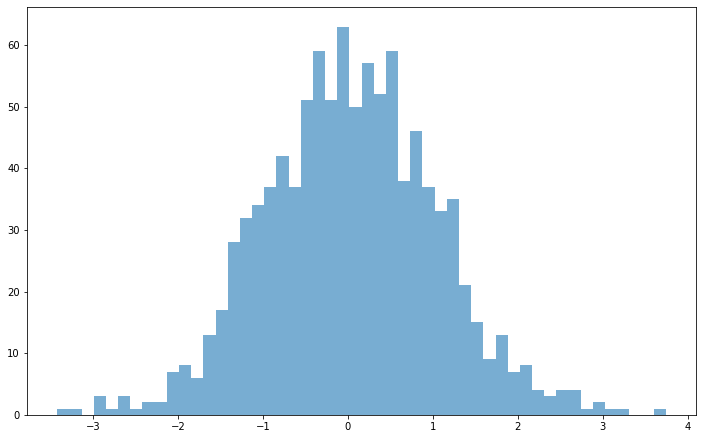

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(12, 7.5))
x = np.random.normal(size=1000)
plt.hist(x, bins=50, alpha = 0.6);

### How to determine the histogram errors?

Assuming that we have selected a bin size, $\Delta_b$, the $N$ values of $x_i$ are sorted into $M$ bins, with the count in each bin $n_k, k = 1, . . . , M$. If we want to express the results as a properly normalized $f(x)$, with the values $f_k$ in each bin, then it is customary to adopt

$$ f_k = \frac{n_k}{\Delta_bN}. $$

The unit for $f_k$ is the inverse of the unit for $x_i$.

Each estimate of $f_k$ comes with some uncertainty. It is customary to assign "error bars" for each $n_k$ equal to $\sqrt{n_k}$ and thus the uncertainty of $f_k$ is

$$\sigma_k = \frac{\sqrt{n_k}}{\Delta_bN} .$$

This practice assumes that $n_k$ are scattered around the true values in each bin ($\mu$) according to a Gaussian distribution, and that error bars enclose the 68% confidence range for the true value. However, when counts are low this assumption of Gaussianity breaks down and the Poisson distribution should be used instead. 

## Selection effects and luminosity function estimation

We will now consider the effects of truncated and censored data sets in more detail and introduce a nonparametric method for correcting the effects of the selection function on the inferred properties of the underlying pdf.

When the selection probability, or selection function $S(x)$ is known (often based on analysis of simulated data sets) and finite, we can use it to correct our estimate $f(x)$. The correction is trivial in the strictly one-dimensional case: the implied true distribution $h(x)$ is obtained from the observed $f(x)$ as

$$ h(x) = \frac{f(x)}{S(x)} $$

When additional observables are available, they might carry additional information about the behavior of the selection function, $S(x)$. One the most important examples in Astronomy is the case of flux-limited sample, as follows.

- Assume that in addition to $x$, we also measure a quantity $y$, and that our selection function is such that $S(x) =1$ for $0 \leq y \leq y_\text{max}(x)$, and $S(x) =0$ for $y > y_\text{max}(x)$, with $x_\text{min} \leq x \leq x_\text{max} $. Here, the observable $y$ may or may not, be related to observable $x$, and the $y \geq 0$ assumption is added for simplicity and without a loss of generality.


- In an astronomical context, $x$ can be thought of as absolute magnitude (a logarithmic measure of luminosity $L$) and $y$ as distance (or redshift in the cosmological context). The differential distribution of luminosity (probability density function) is called the luminosity function. 


- In this example, and for noncosmological distances, we can compute $y_\text{max}(x) = (x/(4\pi F_\text{min}))^{1/2}$, where $F_\text{min}$ is the smallest flux that our measuring apparatus can detect. 

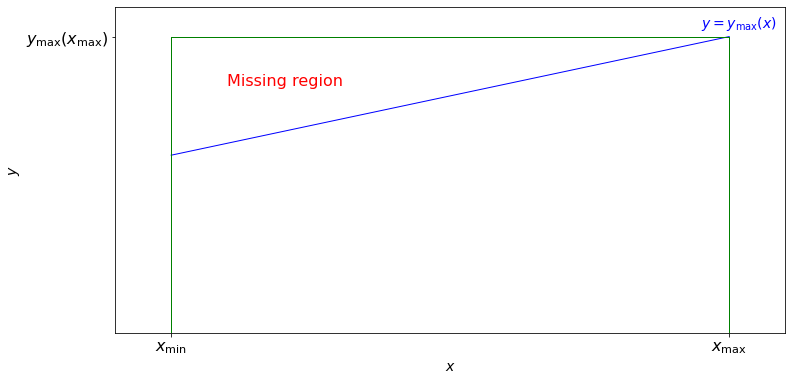

In [88]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6))
max_func = lambda t: 0.4*t+0.6
x = np.linspace(0, 1.0, 100)
ymax = max_func(x)
ymax[ymax > 1] = 1

# plot func and lines
plt.plot(x, ymax, 'b', lw=1)
plt.plot([0, 1], [1, 1], 'g', lw=1)
plt.plot([1, 1], [0, 1], 'g', lw=1)
plt.plot([0, 0], [0, 1], 'g', lw=1)

# add text
plt.text(0.95, 1.03, r'$y = y_{\rm max}(x)$',color = 'b',fontsize = 14)
plt.text(0.1, 0.85, r'Missing region', color = 'r', ha='left', va='center', fontsize = 16)

# adjust the limits
plt.xlim(-0.1, 1.1)
plt.ylim(0, 1.1)
plt.xticks([0,1],[r'$x_{\rm min}$',r'$x_{\rm max}$'],fontsize = 16)
plt.yticks([1],[r'$y_{\rm max}(x_{\rm max})$'],fontsize = 16)
plt.xlabel('$x$', fontsize = 14)
plt.ylabel('$y$', fontsize = 14)

plt.show()

- The observed distribution of our $x$ values is in general different from the distribution we would observe when $S(x) = 1$ for $y \leq (x_\text{max} / 4 \pi F_\text{min}))^{1/2} $ that is, when the "missing region" (shown in the figure above), defined by $y_\text{max}(x) < y \leq (x_\text{max}/ 4 \pi F_\text{min}))^{1/2} = y_\text{max}(x_\text{max}) $, is not excluded. If the two-dimensional probability density is $n(x,y)$, then the latter is given by

$$ h(x) = \int^{y_\text{max}(x_\text{max})}_0 n(x,y) \: dy$$

and the observed distribution corresponds to 

$$ f(x) = \int^{y_\text{max}(x)}_{0} n(x,y) \: dy $$

We can see that the dependence of $n(x,y$) on $y$ directly affects the difference between $f(x)$ and $h(x)$. Therefore, if we want to obtain an estimate of $h(x)$ based on measurements of $f(x)$, we need to estimate $n(x,y)$ first. Using the same example, $n(x,y)$ is the probability of density function per unit luminosity *and* unit distance. Note that there is no guarantee that the luminosity function is the same for near and far distances, that is, $n(x,y)$ need not be separable function of $x$ and $y$.

We can formulate the problem as follows. 

- Given a set of measured pairs $(x_i, y_i)$, with $i = 1,...,N$, and *known* relation $y_\text{max}(x)$ estimate the two-dimensional distribution, $n(x,y)$ from which the sample was drawn. 

- Assume that the measurement errors for both $x$ and $y$ are negligible compared to their observed ranges, that $x$ is measured within a range defined by $x_\text{min}$ and $x_\text{max}$, and that the selection function is 1 for $0 \leq y \leq y_\text{max}(x)$ and $x_\text{min} \leq x \leq x_\text{max}$ and 0 otherwise. 

We will illustrate the definition of a truncated data set and the associated subset used by the Lynden-Bell $C^-$ method the example below. The sample is limited by $x < x_\text{max}$ and $y < y_\text{max}(x)$ (light-shaded area). Associated sets $J_i$ and $J_k$ are shown by the dark-shaded area.

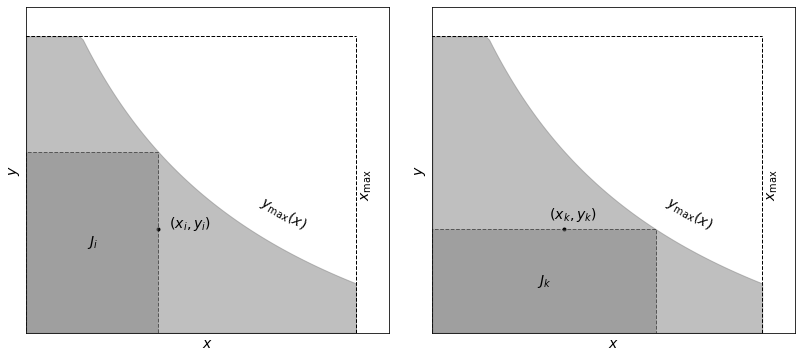

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

#------------------------------------------------------------
# Draw the schematic
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0.06, right=0.95, wspace=0.12)
ax1 = fig.add_subplot(121, xticks=[], yticks=[])
ax2 = fig.add_subplot(122, xticks=[], yticks=[])

# define a convenient function
max_func = lambda t: 1. / (0.5 + t) - 0.5

x = np.linspace(0, 1.0, 100)
ymax = max_func(x)
ymax[ymax > 1] = 1

# draw and label the common background
for ax in (ax1, ax2):
    ax.fill_between(x, 0, ymax, color='gray', alpha=0.5)

    ax.plot([-0.1, 1], [1, 1], '--k', lw=1)

    ax.text(0.7, 0.35, r'$y_{\rm max}(x)$', rotation=-30, fontsize = 14)

    ax.plot([1, 1], [0, 1], '--k', lw=1)
    ax.text(1.01, 0.5, r'$x_{\rm max}$', ha='left', va='center', rotation=90, fontsize = 14)

# draw and label J_i in the first axes
xi = 0.4
yi = 0.35
ax1.scatter([xi], [yi], s=16, lw=0, c='k')
ax1.text(xi + 0.02, yi + 0.02, ' $(x_i, y_i)$', ha='left', va='center',
                        fontsize = 14)
ax1.add_patch(Rectangle((0, 0), xi, max_func(xi), ec='k', fc='gray',
                        linestyle='dashed', lw=1, alpha=0.5))
ax1.text(0.5 * xi, 0.5 * max_func(xi), '$J_i$', ha='center', va='center', fontsize = 14)

# draw and label J_k in the second axes
ax2.scatter([xi], [yi], s=16, lw=0, c='k')
ax2.text(xi + 0.02, yi + 0.02, ' $(x_k, y_k)$', ha='center', va='bottom', 
                         fontsize = 14)
ax2.add_patch(Rectangle((0, 0), max_func(yi), yi, ec='k', fc='gray',
                        linestyle='dashed', lw=1, alpha=0.5))
ax2.text(0.5 * max_func(yi), 0.5 * yi, '$J_k$', ha='center', va='center', fontsize = 14)

# adjust the limits of both axes
for ax in (ax1, ax2):
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('$x$', fontsize = 14)
    ax.set_ylabel('$y$', fontsize = 14)

plt.show()

In general, this problem can be solved by fitting some predefined (assumed) function to the data (i.e., determining a set of best-fit parameters) or in a nonparametric way. An elegant nonparametric solution to this mathematical problem was developed by Lynden-Bell, and shown to be equivalent to or better than other nonparametric methods. Lynden-Bell's method belongs to methods known in statistical literature as product-limit estimators.

### Lynden-Bell's $C^-$ method

Lynden-Bell's nonparametric $C^−$ method can be applied to the above problem when the distributions along the two coordinates $x$ and $y$ are uncorrelated, that is, when we can assume that the bivariate distribution $n(x, y)$ is separable:

$$ n(x,y) = \Psi(x)\rho(y) $$

Therefore, before using the $C^−$ method, we need to demonstrate that this assumption is valid.

Following Lynden-Bell, the basic steps for testing that the bivariate distribution $n(x, y)$ is separable are the following:


>1. Define a comparable or associated set for each object $i$ such that $J_i = \{j: x_j < x_i, y_j < y_\text{max}(x_i)\}$; this is the largest $x$-limited and $y$-limited data subset for object $i$, with $N_i$ elements (see the left panel of the figure above).
>
>2. Sort the set $J_i$ by $y_j$; this gives us the rank $R_j$ for each object (ranging from 1 to $N_i$).
>
>3. Define the rank $R_i$ for object $i$ in its associated set: this is essentially the number of objects
with $y<y_i$ in set $J_i$.
>
>4. Now, if $x$ and $y$ are truly independent, $R_i$ must be distributed uniformly between 0 and $N_i$; in this case, it is trivial to determine the expectation value and variance for $R_i: E(R_i) = E_i = N_i/2$ and $V(R_i) = V_i = N_i^2/12$. We can define the statistic $$ \tau = \frac{\sum_i(R_i-E_i)}{\sqrt{\sum_iV_i}} $$ If $\tau$ < 1, then $x$ and $y$ are uncorrelated at $\sim 1\sigma$ level (this step appears similar to Schmidt’s $V/V_\text{max}$ test discussed below; nevertheless, they are fundamentally different because $V/V_\text{max}$ tests the hypothesis of a uniform distribution in the $y$ direction, while the statistic $\tau$ tests the hypothesis of uncorrelated $x$ and $y$).

Assuming that $\tau < 1$, the cumulative distributions are defined as

$$ \Phi(x) = \int^x_{-\infty} \Psi (x^\prime)\:dx^\prime $$

and

$$ \Sigma (y) = \int^y_{-\infty} \rho(y^\prime)\:dy^\prime. $$

Then,

$$ \Phi (x_i) = \Phi (x_1)\prod^i_{k=2}(1+1/N_k) $$

where it is assumed that $x_i$ are sorted ($x_1 \leq x_k \leq x_N$). Analogously, if $M_k$ is the number of objects in a set defined by $J_k = \{j:y_j < y_k, y_\text{max}(x_j) > y_k\}$ , then
where it is assumed that $x_i$ are sorted ($x_1 \leq x_k \leq x_N$). Analogously, if $M_k$ is the number of objects in a set defined by $J_k = \{j:y_j < y_k, y_\text{max}(x_j) > y_k\}$ (see right panel of figure above), then

$$ \Sigma(y_j) = \Sigma(y_1) \prod ^j_{k=2}(1+1/M_k) $$

Note that both $\Phi(x_j)$ and $\Sigma(y_j)$ are defined on nonuniform grids with $N$ values corresponding to the $N$ measured values. Essentially, the $C^−$ method assumes a piecewise constant model for $\Phi(x)$ and $\Sigma(y)$ between data points (equivalently, differential distributions are modeled as Dirac $\delta$ functions at the position of each data point).

The differential distributions $\Psi(x)$ and $\rho(y)$ can be obtained by binning cumulative distributions in the relevant axis; the statistical noise (errors) for both quantities can be estimated as described in the histogram section or using bootstrap discussed in chapter 3. An approximate normalization can be obtained by requiring that the total predicted number of objects is equal to their observed number.

### *Examples*

#### Model where the answer is known

We'll first illustrate the $C^−$ method using a toy model where the answer is known by estimating a bivariate distribution from a truncated sample. The input distributions are recovered to within uncertainties estimated using bootstrap resampling. First, we will define the input truncated normal distributions. After, we'll define the truncation to be symmetric such that $x_\text{max}(y) = \text{max_func}(y)$ and $y_\text{max}(x) = \text{max_func}(x)$. Next, we can truncate the data and compute the $C^-$ distributions using `bootstrap_Cminus` from `astroML.lumfunc` (with 20 bootstrap resamples).

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from astroML.lumfunc import bootstrap_Cminus

#------------------------------------------------------------
# Define and sample our distributions
N = 10000
np.random.seed(42)

# Define the input distributions for x and y
x_pdf = stats.truncnorm(-2, 1, 0.66666, 0.33333)
y_pdf = stats.truncnorm(-1, 2, 0.33333, 0.33333)

x = x_pdf.rvs(N)
y = y_pdf.rvs(N)

# define the truncation as discussed above
max_func = lambda t: 1. / (0.5 + t) - 0.5

xmax = max_func(y)
xmax[xmax > 1] = 1  # cutoff at x=1

ymax = max_func(x)
ymax[ymax > 1] = 1  # cutoff at y=1

# truncate the data
flag = (x < xmax) & (y < ymax)
x = x[flag]
y = y[flag]
xmax = xmax[flag]
ymax = ymax[flag]

x_fit = np.linspace(0, 1, 21)
y_fit = np.linspace(0, 1, 21)

#------------------------------------------------------------
# compute the Cminus distributions (with bootstrap)
x_dist, dx_dist, y_dist, dy_dist = bootstrap_Cminus(x, y, xmax, ymax,
                                                    x_fit, y_fit,
                                                    Nbootstraps=20,
                                                    normalize=True)

x_mid = 0.5 * (x_fit[1:] + x_fit[:-1])
y_mid = 0.5 * (y_fit[1:] + y_fit[:-1])

Now we plot the results. The lines in the left panel show the true one-dimensional distributions of $x$ and $y$ (truncated Gaussian distributions). A realization of the distribution is shown in the right panel, with a truncation given by the solid line. The points in the left panel are computed from the truncated data set using the $C^-$ method above.

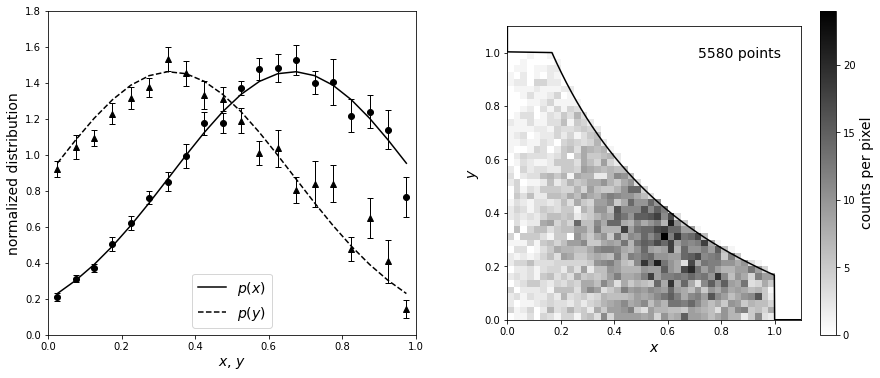

In [5]:
fig = plt.figure(figsize=(14, 6))
fig.subplots_adjust(bottom=0.2, top=0.95,
                    left=0.1, right=0.92, wspace=0.25)

# First subplot is the true & inferred 1D distributions
ax = fig.add_subplot(121)
ax.plot(x_mid, x_pdf.pdf(x_mid), '-k', label='$p(x)$')
ax.plot(y_mid, y_pdf.pdf(y_mid), '--k', label='$p(y)$')
ax.legend(loc='lower center' , fontsize= 14)

ax.errorbar(x_mid, x_dist, dx_dist, 
            fmt='ok', ecolor='k', lw=1, ms=6, capsize = 3)
ax.errorbar(y_mid, y_dist, dy_dist, 
            fmt='^k', ecolor='k', lw=1, ms=6, capsize = 3)

ax.set_ylim(0, 1.8)
ax.set_xlim(0, 1)
ax.set_xlabel('$x$, $y$', fontsize= 14)
ax.set_ylabel('normalized distribution', fontsize= 14)

# Second subplot is the "observed" 2D distribution
ax = fig.add_subplot(122)
H, xb, yb = np.histogram2d(x, y, bins=np.linspace(0, 1, 41))
plt.imshow(H.T, origin='lower', interpolation='nearest',
           extent=[0, 1, 0, 1], cmap=plt.cm.binary)
cb = plt.colorbar()

x_limit = np.linspace(-0.1, 1.1, 1000)
y_limit = max_func(x_limit)
x_limit[y_limit > 1] = 0
y_limit[x_limit > 1] = 0
ax.plot(x_limit, y_limit, '-k')

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_xlabel('$x$', fontsize= 14)
ax.set_ylabel('$y$', fontsize= 14)
cb.set_label('counts per pixel', fontsize= 14)
ax.text(0.93, 0.93, '%i points' % len(x), ha='right', va='top',
        transform=ax.transAxes, fontsize= 14)

plt.show()

#### Realistic example where answer is not known

A realistic example is based on two samples of galaxies with SDSS spectra. 

A flux-limited sample of galaxies with an r-band magnitude cut of $r < 17.7$ is selected from the redshift range $0.08 < z < 0.12$, and separated into blue and red subsamples using the color boundary $u−r = 2.22$. 

- These color-selected subsamples closely correspond to spiral and elliptical galaxies and are expected to have different luminosity distributions. 
- Absolute magnitudes were computed from the distance modulus based on the spectroscopic redshift, assuming WMAP cosmology. For simplicity, we ignore $K$ corrections, whose effects should be very small for this redshift range. 

First we will fetch SDSS data from `astroML.datasets.fetch_sdss_specgals` and make redshift/magnitude cuts defined above. Next, using the fact that $u-r = 2.22$, we can split the data into red and blue subsamples.

In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt

from scipy import interpolate
from astropy.cosmology import FlatLambdaCDM

from astroML.lumfunc import bootstrap_Cminus
from astroML.datasets import fetch_sdss_specgals

#------------------------------------------------------------
# Get the data and perform redshift/magnitude cuts
data = fetch_sdss_specgals()

z_min = 0.08
z_max = 0.12
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > z_min]
data = data[data['z'] < z_max]
data = data[data['petroMag_r'] < m_max]

# divide red sample and blue sample based on u-r color
ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

# truncate sample (optional: speeds up computation)
print(data_red.size, "red galaxies")
print(data_blue.size, "blue galaxies")

114152 red galaxies
45010 blue galaxies


Next, we will calculate the distance modulus. To do this, we'll need functions to approximate $\mu(z)$ and $z(\mu)$ where $z$ is redshift and $\mu$ is distance modulus. We'll accomplish this using the cosmology class and scipy's cubic spline interpolation. After, we'll create a function to compute the luminosity function. We'll use Lynden-Bell’s method, with errors determined by 20 bootstrap resamples. 

In [7]:
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=0)
z_sample = np.linspace(0.01, 1.5, 100)
mu_sample = cosmo.distmod(z_sample).value
mu_z = interpolate.interp1d(z_sample, mu_sample)
z_mu = interpolate.interp1d(mu_sample, z_sample)

data = [data_red, data_blue]
titles = ['$u-r > 2.22$', '$u-r < 2.22$']
markers = ['o', '^']
archive_files = ['lumfunc_red.npz', 'lumfunc_blue.npz']


def compute_luminosity_function(z, m, M, m_max, archive_file):
    """Compute the luminosity function and archive in the given file.
    If the file exists, then the saved results are returned.
    """
    Mmax = m_max - (m - M)
    zmax = z_mu(m_max - M)

    if not os.path.exists(archive_file):
        print("- computing bootstrapped luminosity function ",
              "for {0} points".format(len(z)))

        zbins = np.linspace(0.08, 0.12, 21)
        Mbins = np.linspace(-24, -20.2, 21)
        dist_z, err_z, dist_M, err_M = bootstrap_Cminus(z, M, zmax, Mmax,
                                                        zbins, Mbins,
                                                        Nbootstraps=20,
                                                        normalize=True)

        np.savez(archive_file,
                 zbins=zbins, dist_z=dist_z, err_z=err_z,
                 Mbins=Mbins, dist_M=dist_M, err_M=err_M)
    else:
        print("- using precomputed bootstrapped luminosity function results")
        archive = np.load(archive_file)
        zbins = archive['zbins']
        dist_z = archive['dist_z']
        err_z = archive['err_z']
        Mbins = archive['Mbins']
        dist_M = archive['dist_M']
        err_M = archive['err_M']

    return zbins, dist_z, err_z, Mbins, dist_M, err_M

Now, we'll plot the results. The left panels show the distribution of sources as a function of redshift and absolute magnitude. The results of
$p(z,M) = \rho(z)\Phi(m)$ are shown in the right panels. For the redshift distribution, we multiply the result by $z^2$ for clarity. Note that the most luminous galaxies belong to the photometrically red subsample, as discernible in the bottom-right panel.

- using precomputed bootstrapped luminosity function results
- using precomputed bootstrapped luminosity function results


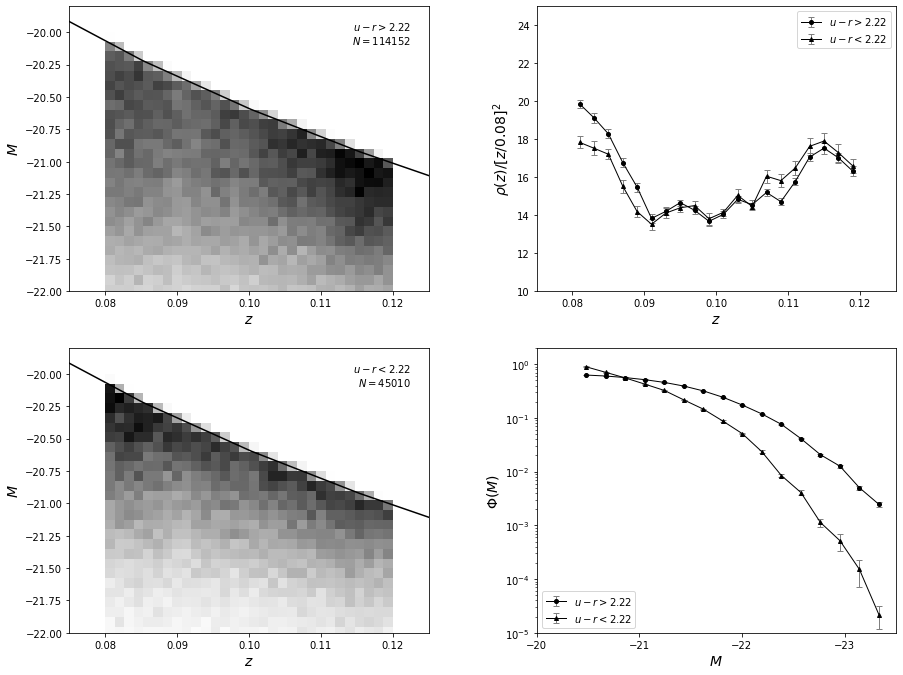

In [11]:
# Perform the computation and plot the results
fig = plt.figure(figsize=(14, 10))
fig.subplots_adjust(left=0.13, right=0.95, wspace=0.3,
                    bottom=0.08, top=0.95, hspace=0.2)

ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 4, yscale='log')

for i in range(2):
    m = data[i]['petroMag_r']
    z = data[i]['z']
    M = m - mu_z(z)

    # compute the luminosity function for the given subsample
    zbins, dist_z, err_z, Mbins, dist_M, err_M = \
        compute_luminosity_function(z, m, M, m_max, archive_files[i])

    #------------------------------------------------------------
    # First axes: plot the observed 2D distribution of (z, M)
    ax = fig.add_subplot(2, 2, 1 + 2 * i)
    H, xbins, ybins = np.histogram2d(z, M, bins=(np.linspace(0.08, 0.12, 31),
                                                 np.linspace(-23, -20, 41)))
    ax.imshow(H.T, origin='lower', aspect='auto',
              interpolation='nearest', cmap=plt.cm.binary,
              extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))

    # plot the cutoff curve
    zrange = np.linspace(0.07, 0.13, 100)
    Mmax = m_max - mu_z(zrange)
    ax.plot(zrange, Mmax, '-k')

    ax.text(0.95, 0.95, titles[i] + "\n$N = %i$" % len(z),
            ha='right', va='top',
            transform=ax.transAxes)

    ax.set_xlim(0.075, 0.125)
    ax.set_ylim(-22, -19.8)
    ax.set_xlabel('$z$', fontsize = 14)
    ax.set_ylabel('$M$', fontsize = 14)

    #------------------------------------------------------------
    # Second axes: plot the inferred 1D distribution in z
    factor = 0.08 ** 2 / (0.5 * (zbins[1:] + zbins[:-1])) ** 2
    ax2.errorbar(0.5 * (zbins[1:] + zbins[:-1]),
                 factor * dist_z, factor * err_z,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i], capsize=3)

    #------------------------------------------------------------
    # Third axes: plot the inferred 1D distribution in M
    # truncate the bins so the plot looks better
    Mbins = Mbins[3:-1]
    dist_M = dist_M[3:-1]
    err_M = err_M[3:-1]
    
    ax3.errorbar(0.5 * (Mbins[1:] + Mbins[:-1]), dist_M, err_M,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i], capsize=3)


#------------------------------------------------------------
# set labels and limits
ax2.legend(loc=1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.set_xlabel(r'$z$', fontsize = 14)
ax2.set_ylabel(r'$\rho(z) / [z / 0.08]^2$', fontsize = 14)
ax2.set_xlim(0.075, 0.125)
ax2.set_ylim(10, 25)

ax3.legend(loc=3)
ax3.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax3.set_xlabel(r'$M$', fontsize = 14)
ax3.set_ylabel(r'$\Phi(M)$', fontsize = 14)
ax3.set_xlim(-20, -23.5)
ax3.set_ylim(1E-5, 2)

plt.show()

As expected, the difference in luminosity functions is easily discernible in the figure above. Due to the large sample size, statistical uncertainties are very small. True uncertainties are dominated by systematic errors because we did not take evolutionary and $K$ corrections into account; we assumed that the bivariate distribution is separable, and we assumed that the selection function is unity.